# V624 Tau

In [1]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation

First, let's take a look at the original light curve from the Kepler pipeline.

In [2]:
target = 'V624 Tau'

search = lk.search_lightcurve(target, cadence='short', mission='K2')
search

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,K2 Campaign 04,2015,K2,60,ktwo211088007,0.0


In [3]:
og_lc = search.download()

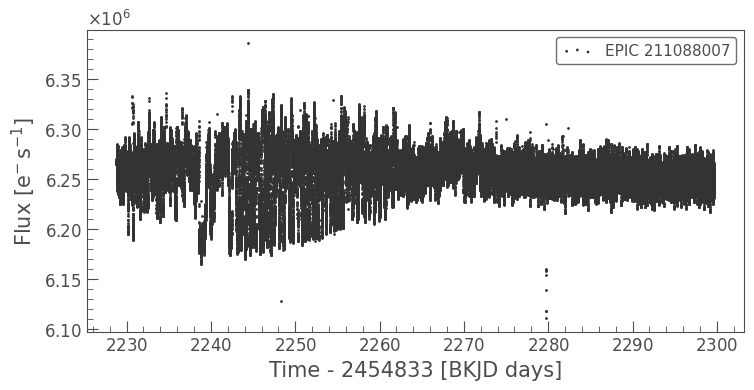

In [4]:
og_lc.scatter();

There are segments of the light curve that look fine, particularly the second half.

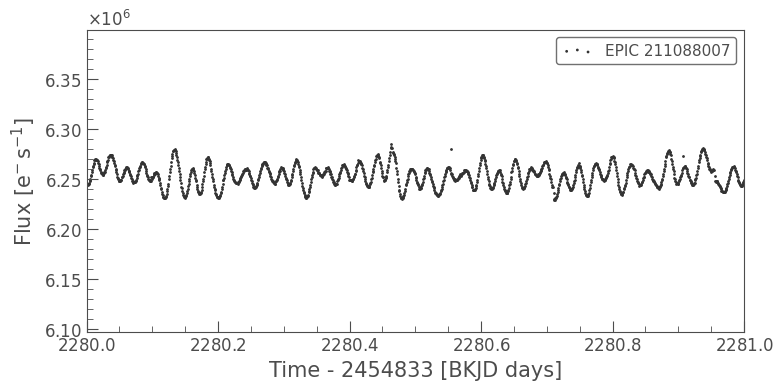

In [5]:
ax = og_lc.scatter()
ax.set_xlim(2280,2281);

But other segments have strong systematic errors.

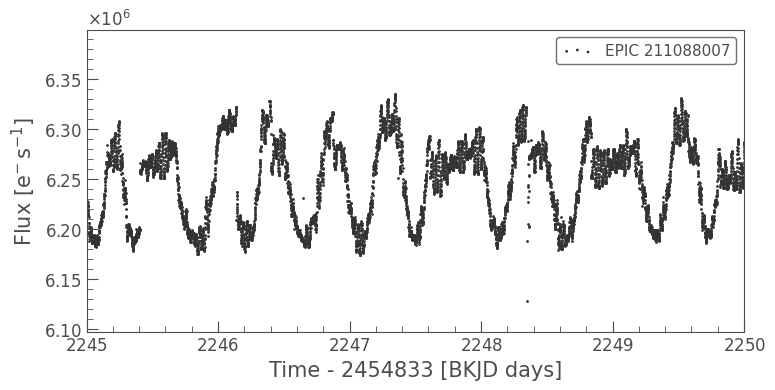

In [6]:
ax = og_lc.scatter()
ax.set_xlim(2245,2250);

These systematic errors will correllate with the position of the star on the detector, and can corrected for using a method such as the Self Flat-Fielding (SFF) method described by Vanderburg and Johnson (2014). We can also choose an improved aperture.

In [7]:
search = lk.search_targetpixelfile(target, cadence='short', mission='K2')
search

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,K2 Campaign 04,2015,K2,60,ktwo211088007,0.0


In [8]:
tpf = search.download()

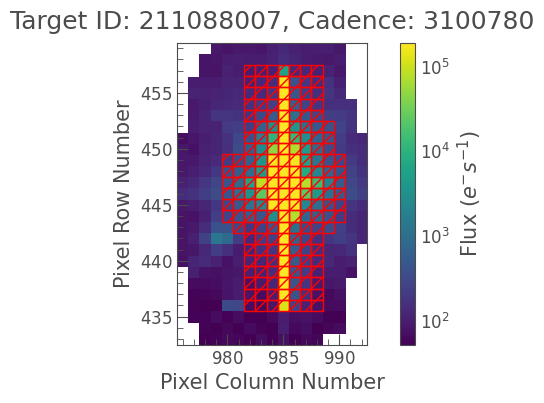

In [9]:
tpf[0].plot(scale='log',aperture_mask=tpf.pipeline_mask);

It looks like the pipeline aperture may be too small, and losses may occur as the star moves across the CCD with the spacecraft motion.

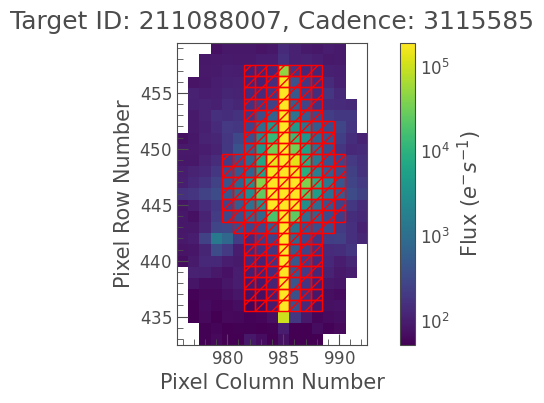

In [10]:
tpf[14734].plot(scale='log',aperture_mask=tpf.pipeline_mask);

As indeed is the case above. So we can choose new apertures, and perform any further corrections using the SSF method. Additionally, because the behaviour of the spacecraft motion changes over the campaign, it is best to split the light curve up into different sections to perform any corrections.

In [11]:
#First segment
t1 = 0
t2 = 14251

#Create new aperture mask
mask = tpf[t1:t2].create_threshold_mask(threshold=5)

#Dilate mask to minimise aperture losses with spacecraft motion
mask = binary_dilation(mask,iterations=2)

#Additional changes to aperture mask to ensure the bleed column is always included:
mask[2:-2,9] = True
mask[2:-2,10] = True
mask[5:-4,11] = True

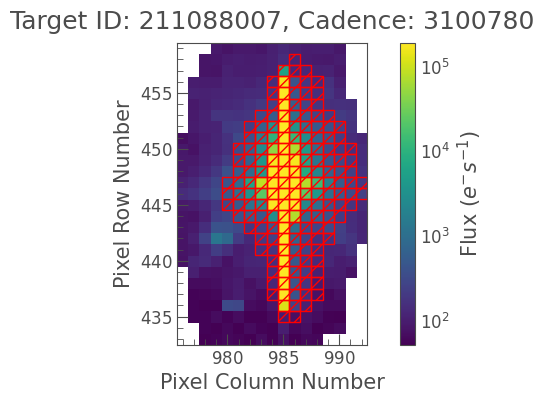

In [12]:
tpf[t1].plot(scale='log',aperture_mask=mask);

In [13]:
lc1 = tpf[t1:t2].to_lightcurve(aperture_mask = mask)

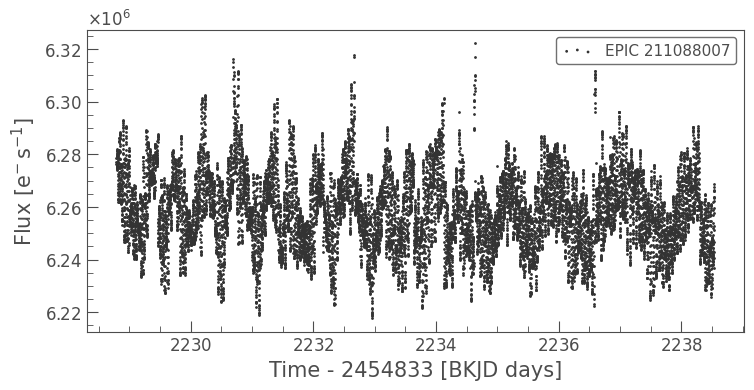

In [14]:
lc1.scatter();

The high-frequency, delta Scuti pulations are clear in this light curve, as are some slower variations that may be related to the pointing drift. To confirm, we check if they are correlated with the target position:

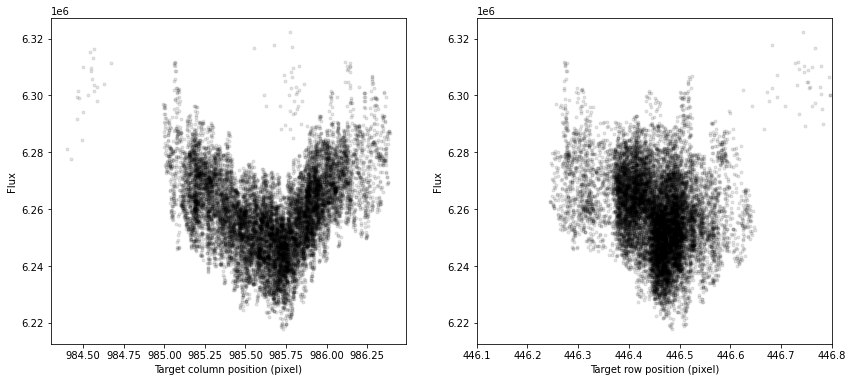

In [15]:
fig,ax = plt.subplots(1,2,figsize=(14,6))

ax[0].plot(lc1.centroid_col,lc1.flux,'.', c='k',alpha=0.1)
ax[0].set_xlabel('Target column position (pixel)')
ax[0].set_ylabel('Flux')

ax[1].plot(lc1.centroid_row,lc1.flux,'.', c='k',alpha=0.1)
ax[1].set_xlabel('Target row position (pixel)')
ax[1].set_ylabel('Flux')
ax[1].set_xlim(446.1,446.8)

plt.show()

plt.show()

There does indeed seem to be some correlation with position. We can adjust this using the `SSFCorrector` method implemented in lightkurve:

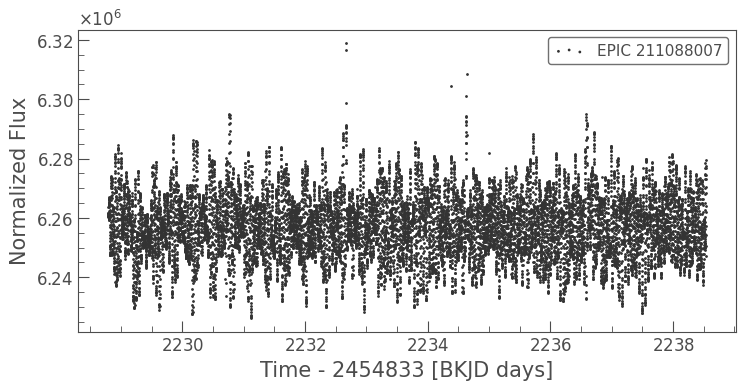

In [16]:
corrector = lc1.remove_outliers().to_corrector("sff")
corr_lc1 = corrector.correct(windows=1)
corr_lc1.scatter();

The corrector appears to have done an excellent job, which we can confirm by checking the diagnostic plots:

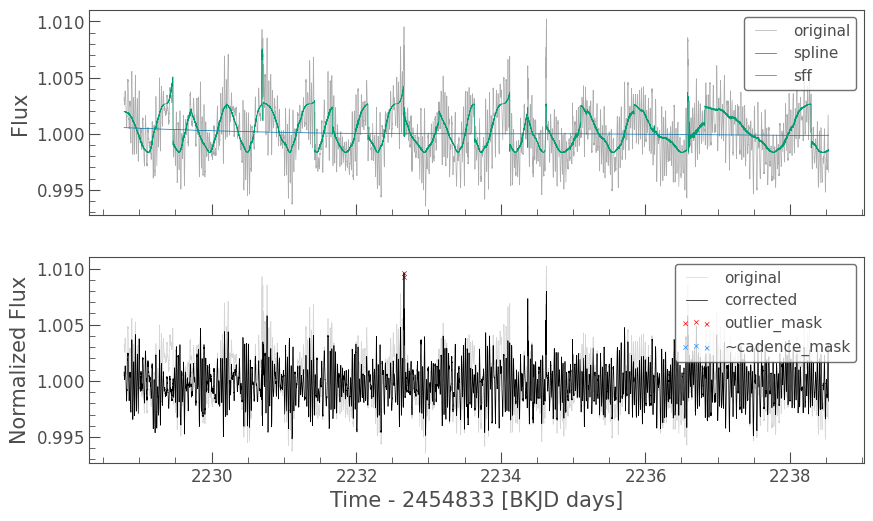

In [17]:
corrector.diagnose();

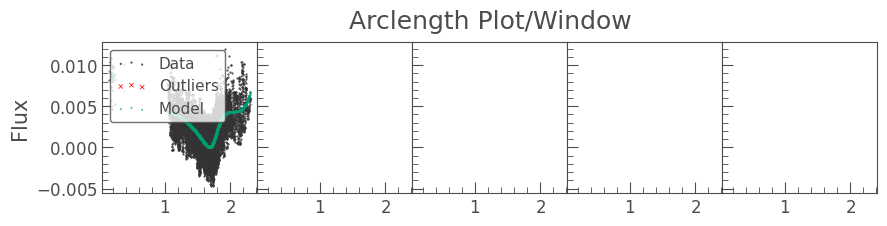

In [18]:
corrector.diagnose_arclength()

Now we can move on to the second segment of the light curve.

In [19]:
#Second segment
t1 = 14251
t2 = 62809

#Create new aperture mask
mask = tpf[t1:t2].create_threshold_mask(threshold=5)

#Dilate mask to minimise aperture losses with spacecraft motion
mask = binary_dilation(mask,iterations=1)

#Additional changes to aperture mask to ensure the bleed column is always included:
mask[5:-5,8] = True
mask[2:-2,9] = True
mask[2:-2,10] = True

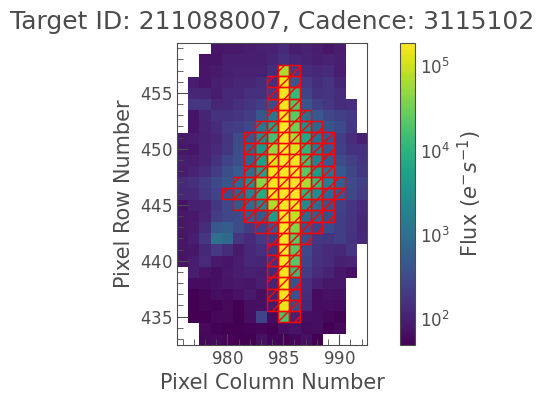

In [20]:
tpf[t1].plot(scale='log',aperture_mask=mask);

In [21]:
lc2 = tpf[t1:t2].to_lightcurve(aperture_mask = mask)

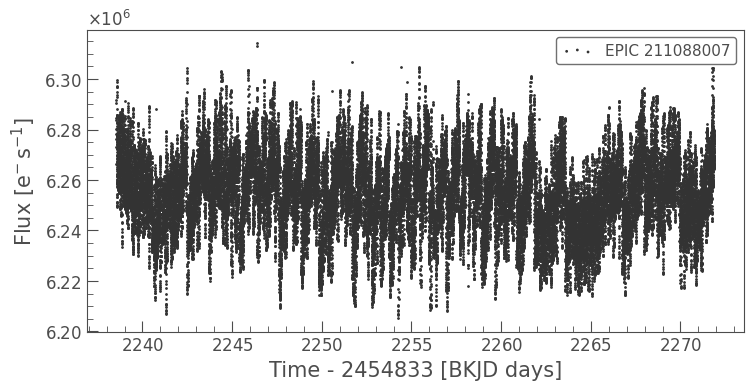

In [22]:
lc2.remove_outliers().scatter();

This already appears to be an impovement over the original light curve, however pointing systematics still remain that, again we can correct for using `SSFCorrector`.

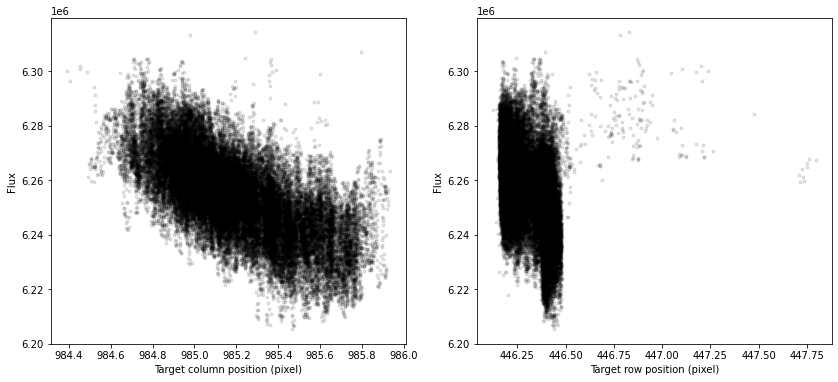

In [23]:
fig,ax = plt.subplots(1,2,figsize=(14,6))

ax[0].plot(lc2.remove_outliers().centroid_col,lc2.remove_outliers().flux,'.', c='k',alpha=0.1)
ax[0].set_xlabel('Target column position (pixel)')
ax[0].set_ylabel('Flux')

ax[1].plot(lc2.remove_outliers().centroid_row,lc2.remove_outliers().flux,'.', c='k',alpha=0.1)
ax[1].set_xlabel('Target row position (pixel)')
ax[1].set_ylabel('Flux')
# ax[1].set_xlim(446.1,446.8)

plt.show()

plt.show()

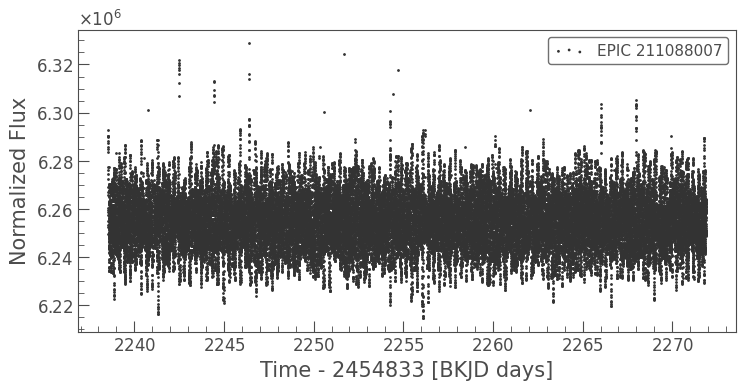

In [24]:
corrector = lc2.remove_outliers().to_corrector("sff")
corr_lc2 = corrector.correct(windows=1)
corr_lc2.scatter();

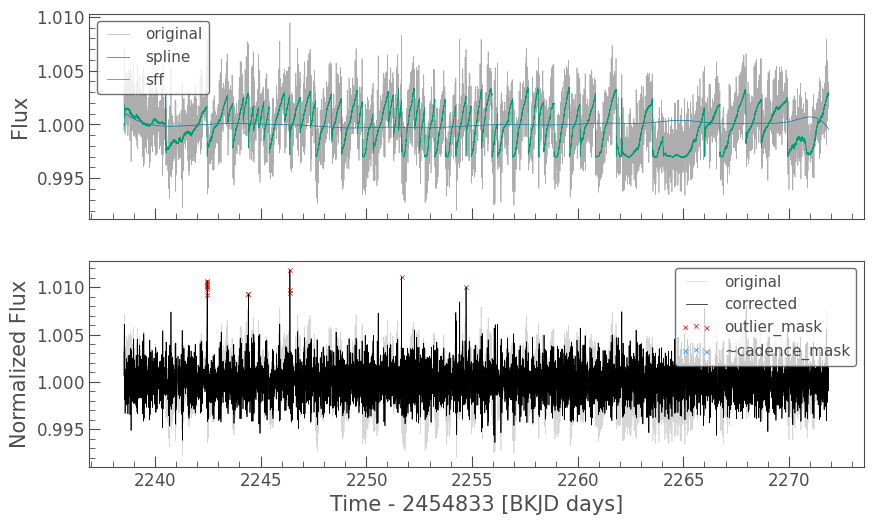

In [25]:
corrector.diagnose()

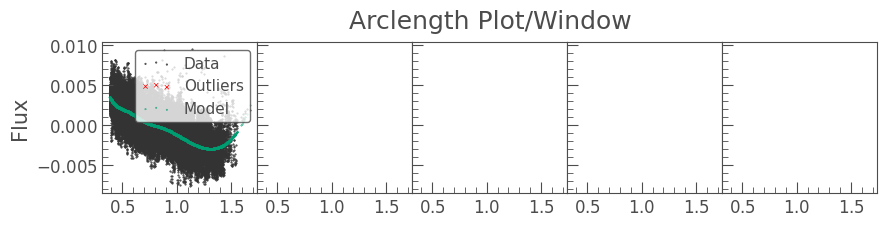

In [26]:
corrector.diagnose_arclength()

Again the new light curve is excellent. Now onto the third and final light curve segment:

In [27]:
#Third segment
t1 = 62809

#Create new aperture mask
mask = tpf[t1:].create_threshold_mask(threshold=5)

#Dilate mask to minimise aperture losses with spacecraft motion
mask = binary_dilation(mask,iterations=1)

#Additional changes to aperture mask to ensure the bleed column is always included:
mask[3:-3,9] = True
mask[3:-2,10] = True
mask[4:-3,11] = True
mask[5:-4,12] = True
mask[10:20,13] = True
mask[11:19,14] = True

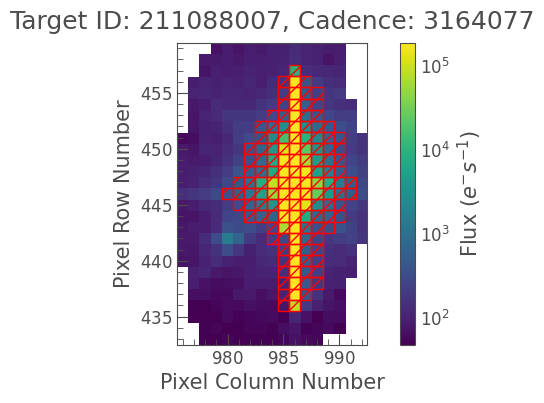

In [28]:
tpf[t1].plot(scale='log',aperture_mask=mask);

In [29]:
lc3 = tpf[t1:].to_lightcurve(aperture_mask = mask)

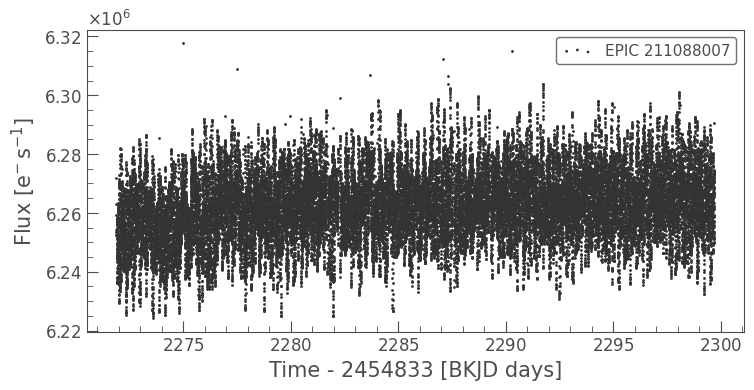

In [30]:
lc3.remove_outliers().scatter();

Already this segment looks good, as it did in the original light curve. We can, however, still run the corrector to remove any small residual pointing systematics.

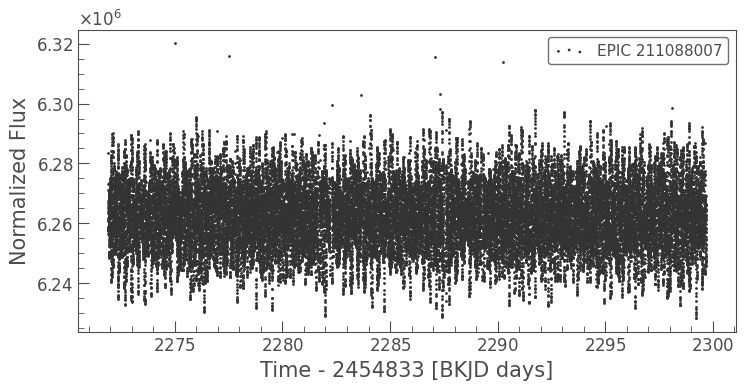

In [31]:
corrector = lc3.remove_outliers().to_corrector("sff")
corr_lc3 = corrector.correct(windows=1)
corr_lc3.scatter();

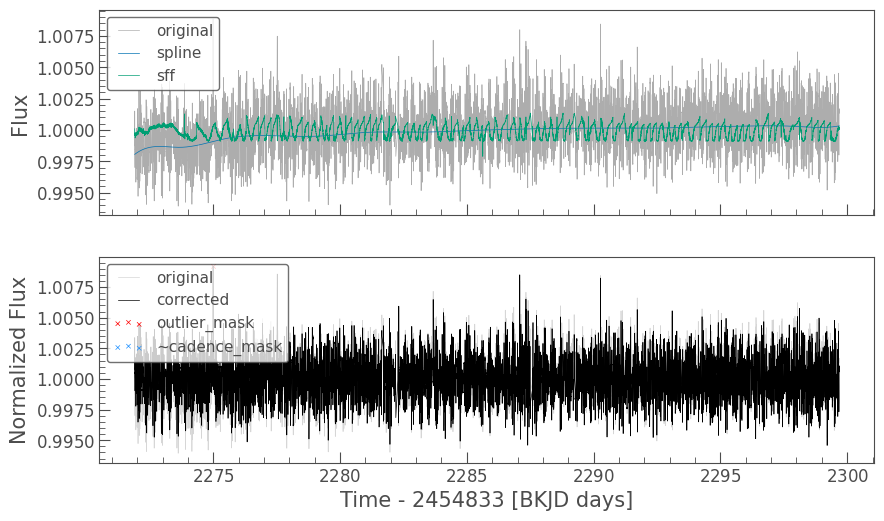

In [32]:
corrector.diagnose()

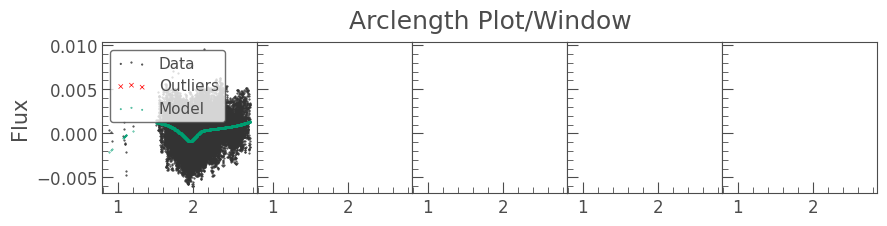

In [33]:
corrector.diagnose_arclength()

All that's left to do now is to combine the segments into the final light curve.

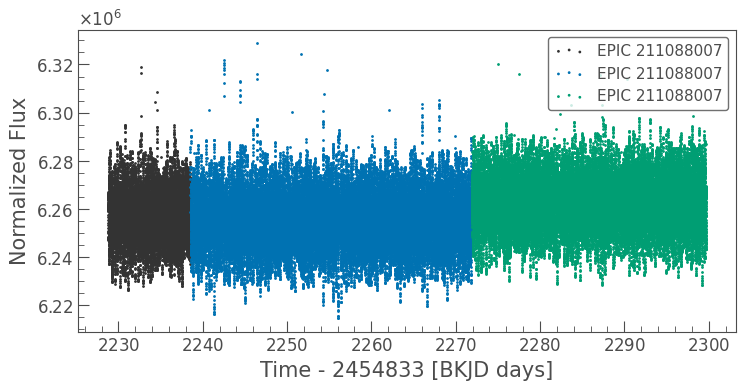

In [34]:
ax = corr_lc1.scatter()
corr_lc2.scatter(ax=ax)
corr_lc3.scatter(ax=ax);

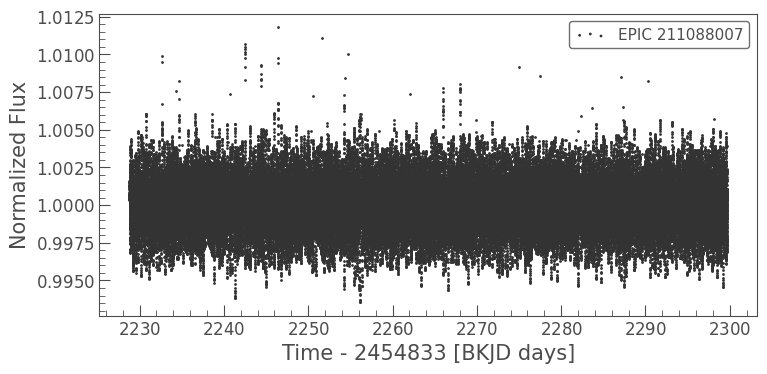

In [35]:
final_lc = corr_lc1.normalize().append(corr_lc2.normalize()).append(corr_lc3.normalize())
final_lc.scatter();

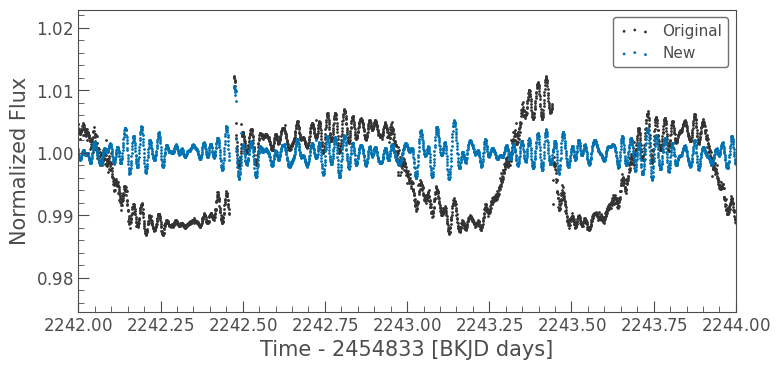

In [36]:
ax = og_lc.normalize().scatter(label='Original')
final_lc.scatter(ax=ax,label='New')
# ax.set_ylim(0.95,1.05)
ax.set_xlim(2242,2244)
plt.show();

That looks better!

In [37]:
final_lc.to_csv(path_or_buf='../lightcurves/V624Tau_SC_C4_SYDSAP.csv')
final_lc.to_fits('../lightcurves/V624Tau_SC_C4_SYDSAP.fits')